# Sentiment Analysis on Twiter data on Stocks

In [1]:
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns

import json, nltk
import re

from helper import plot_history

data_dir = '../nlp_datasets/12_twitter_sentiment/'

In [2]:
def load_data():
    with open(data_dir+'train_twits.json', 'r') as f:
        twits = json.load(f)
    df = pd.DataFrame(twits['data'])
    return df
    
data = load_data()

In [3]:
print (f"data shape:{data.shape}")
data.head(2)

data shape:(1548010, 3)


,message_body,sentiment,timestamp
0,$FITB great buy at 26.00...ill wait,2,2018-07-01T00:00:09Z
1,@StockTwits $MSFT,1,2018-07-01T00:00:42Z


In [4]:
# cut the data short to make learning faster keep only 8010 of them
#random_indices = np.random.choice(range(df.shape[0]), size=8010)
#df = df.loc[random_indices]
df_top = data.loc[:10000]

In [5]:
df= df_top.copy()
df.sentiment.unique()

array([ 2,  1,  0, -2, -1])

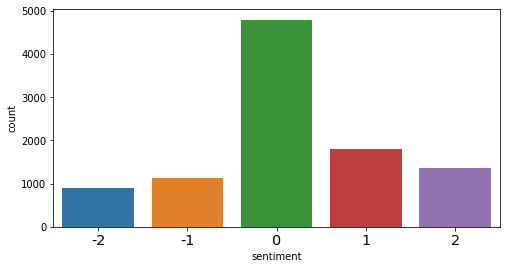

In [6]:
def Countplot(df, col):    
    fig, ax = plt.subplots(1,1,figsize=(8,4));
    sns.countplot(df[col], ax=ax);
    plt.xticks(fontsize='x-large');
    
Countplot(df, 'sentiment')

this means almost half of the tweets are neutral in the sentiment. a classic example of unbalanced data set. One way to treat this is to remove the neutral data so that the class becomes more or less neutral. Here we'll make the counts of sentiment 2 and sentiment 3 equal.

## Class (Im)balance

initial counts for each classes: {0: 4799, 1: 1806, 2: 1367, -1: 1127, -2: 902}
min_index: -2 min count: 902


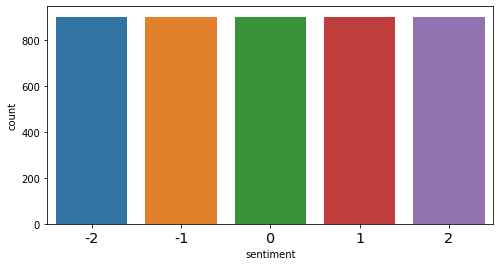

In [7]:
def balance_class(df, col='sentiment'):
    dfb=df.copy()
    counts = dict(dfb[col].value_counts())
    print ("initial counts for each classes:", counts)
    min_count = min(counts.values())
    min_indx  = [k for k in counts.keys() if counts[k]==min_count][0]
    print ("min_index:", min_indx, "min count:", min_count)

    for s in dfb[col].unique():
        delete_after = dfb[dfb[col]==min_indx].shape[0] 
        indices_to_delete = dfb[dfb[col]==s].index.values[delete_after:]
        dfb = dfb.drop(index=indices_to_delete, axis=0)
    return dfb

df=balance_class(df, col='sentiment')
Countplot(df, 'sentiment')

In [8]:
# convert the labels to [1-5] instead of [-2, 2]
df['sentiment'] = df['sentiment'].apply(lambda x:x+2)

In [9]:
print ( "unique sentiments:",df.sentiment.unique() )
print (f"data shape:{df.shape}")
df.head(5)

unique sentiments: [4 3 2 0 1]
data shape:(4510, 3)


,message_body,sentiment,timestamp
0,$FITB great buy at 26.00...ill wait,4,2018-07-01T00:00:09Z
1,@StockTwits $MSFT,3,2018-07-01T00:00:42Z
2,#STAAnalystAlert for $TDG : Jefferies Maintain...,4,2018-07-01T00:01:24Z
3,$AMD I heard there’s a guy who knows someone w...,3,2018-07-01T00:01:47Z
4,$AMD reveal yourself!,2,2018-07-01T00:02:13Z


In [10]:
print (f" new data shape:{df.shape}")
df.head(2)

 new data shape:(4510, 3)


,message_body,sentiment,timestamp
0,$FITB great buy at 26.00...ill wait,4,2018-07-01T00:00:09Z
1,@StockTwits $MSFT,3,2018-07-01T00:00:42Z


In [12]:
def print_twts():
    for i in df.sentiment.unique():
        print ("Tweets with sentiment: ", i)
        twt=df[df['sentiment']==i].sample(3)['message_body'].values
        for i in range(3):
            print (twt[i])
            print ()
        print ("===================")
        print ()
        
print_twts()

Tweets with sentiment:  4
$WYNN 200 shares holding till ER

$MU last year same time, 12 months price targets reached $75. So there is hope for a rebound if China trade issue is resolved quickly .

$MU the hell with it. This is a cheap stock and I’m sticking with it. Patience my fellow bulls. Either my bet is going to make me money or .


Tweets with sentiment:  3
@StockTwits I think $AMZN In my opinion,it is the most consolidated,&amp; with the greatest business support in different areas and strategies.

$MU Congrats to those who bought the dip!

$MU hell no, this stock is impossible to move upwards.  Maybe high 50’s at most


Tweets with sentiment:  2
Today&#39;s insight on $RRD https://app.seasonaledge.com/tools/I/RRD

$AAPL has a Return On Assets of 14.51%. This is amongst the best returns in the industry. https://www.chartmill.com/analyze.php?utm_source=stocktwits&amp;utm_medium=FA&amp;utm_content=PROFITABILITY&amp;utm_campaign=social_tracking#/AAPL?r=fa&amp;key=bb853040-a4ac-41c6

In [13]:

def preprocess_twt(message):
    text = message.lower()                   # Lowercase the twit message
    text = re.sub(r'https?://\S+', ' ', text)# Replace URLs with a space
    text = re.sub(r'\$\S+', ' ', text)       # Replace ticker symbols with a space
    text = re.sub(r'\@\S+', ' ', text)       # Replace StockTwits usernames with a space.
    text = re.sub(r'[^a-zA-Z]', ' ', text)   # Replace everything not a letter with a space
    
    # Tokenize    
    tokens = nltk.tokenize.word_tokenize(text)

    # Lemmatize words using the WordNetLemmatizer.
    # Ignore any word that is not longer than one character.
    wnl = nltk.stem.WordNetLemmatizer()
    tokens = [wnl.lemmatize(token) for token in tokens if len(token) > 1]
    
    return tokens

df['message_tokenized'] = df["message_body"].apply(preprocess_twt)

In [14]:
df.head(2)

,message_body,sentiment,timestamp,message_tokenized
0,$FITB great buy at 26.00...ill wait,4,2018-07-01T00:00:09Z,"[great, buy, at, ill, wait]"
1,@StockTwits $MSFT,3,2018-07-01T00:00:42Z,[]


In [15]:
from collections import Counter

"""
Create a vocabulary by using Bag of words
"""

tokenized_words = [word for twit in df.message_tokenized for word in twit]
bow = Counter(tokenized_words)

In [16]:
bow.most_common(15)

[('to', 1307),
 ('the', 1254),
 ('is', 1106),
 ('on', 951),
 ('for', 922),
 ('of', 875),
 ('in', 782),
 ('and', 670),
 ('short', 635),
 ('this', 632),
 ('it', 547),
 ('at', 450),
 ('are', 376),
 ('down', 367),
 ('will', 354)]

In [17]:
def remove_words(bow, low_cutoff=1e-5, high_cutoff=10):
    # remove the words which are outside the cutoff range
    # they usually are too common or too rare to make any big impact on the analysis
    total_cnt = sum(bow.values())
    
    freqs = dict(bow)
    for key in freqs:
        freqs[key] = freqs[key]/total_cnt
        
    K_most_common = [word[0] for word in bow.most_common(high_cutoff)]
    
    filtered_words = [word for word in freqs if (freqs[word] > low_cutoff and word not in K_most_common)]
    
    return freqs, filtered_words


In [18]:
freqs, filtered_words= remove_words(bow)

In [19]:
def prepare_vocab_dict(filtered_words):
    # A dictionary for the `filtered_words`.
    vocab = {word:idx+1 for idx, word in enumerate(filtered_words)}
    # reverse the vocab dictionary
    id2vocab = {idx:word for word, idx in vocab.items()}
    return vocab, id2vocab

vocab, id2vocab = prepare_vocab_dict(filtered_words)

In [20]:
print ("Top 5 word to index items")
for item in list(vocab.items())[:5]:
    print (item)
    
print ("\nTop 5 index to words items")
for item in list(id2vocab.items())[:5]:
    print (item)


Top 5 word to index items
('great', 1)
('buy', 2)
('at', 3)
('ill', 4)
('wait', 5)

Top 5 index to words items
(1, 'great')
(2, 'buy')
(3, 'at')
(4, 'ill')
(5, 'wait')


In [21]:
def filter_twit(words, filtered_words):
     return [word for word in words if word in filtered_words]

tmp = df['message_tokenized'].values[50]
print (tmp)
filter_twit(tmp, filtered_words)

['how', 'expect', 'the', 'earnings']


['how', 'expect', 'earnings']

In [22]:
df['filtered'] = df['message_tokenized'].apply(filter_twit, filtered_words=filtered_words)

In [23]:
df.head(5)

,message_body,sentiment,timestamp,message_tokenized,filtered
0,$FITB great buy at 26.00...ill wait,4,2018-07-01T00:00:09Z,"[great, buy, at, ill, wait]","[great, buy, at, ill, wait]"
1,@StockTwits $MSFT,3,2018-07-01T00:00:42Z,[],[]
2,#STAAnalystAlert for $TDG : Jefferies Maintain...,4,2018-07-01T00:01:24Z,"[staanalystalert, for, jefferies, maintains, w...","[staanalystalert, jefferies, maintains, with, ..."
3,$AMD I heard there’s a guy who knows someone w...,3,2018-07-01T00:01:47Z,"[heard, there, guy, who, know, someone, who, t...","[heard, there, guy, who, know, someone, who, t..."
4,$AMD reveal yourself!,2,2018-07-01T00:02:13Z,"[reveal, yourself]","[reveal, yourself]"


In [24]:
# delete texts with zero length
df['counts'] = df.filtered.apply(len)
df.head()

,message_body,sentiment,timestamp,message_tokenized,filtered,counts
0,$FITB great buy at 26.00...ill wait,4,2018-07-01T00:00:09Z,"[great, buy, at, ill, wait]","[great, buy, at, ill, wait]",5
1,@StockTwits $MSFT,3,2018-07-01T00:00:42Z,[],[],0
2,#STAAnalystAlert for $TDG : Jefferies Maintain...,4,2018-07-01T00:01:24Z,"[staanalystalert, for, jefferies, maintains, w...","[staanalystalert, jefferies, maintains, with, ...",15
3,$AMD I heard there’s a guy who knows someone w...,3,2018-07-01T00:01:47Z,"[heard, there, guy, who, know, someone, who, t...","[heard, there, guy, who, know, someone, who, t...",12
4,$AMD reveal yourself!,2,2018-07-01T00:02:13Z,"[reveal, yourself]","[reveal, yourself]",2


In [25]:
df = df[df['counts']>0]
df.head()

,message_body,sentiment,timestamp,message_tokenized,filtered,counts
0,$FITB great buy at 26.00...ill wait,4,2018-07-01T00:00:09Z,"[great, buy, at, ill, wait]","[great, buy, at, ill, wait]",5
2,#STAAnalystAlert for $TDG : Jefferies Maintain...,4,2018-07-01T00:01:24Z,"[staanalystalert, for, jefferies, maintains, w...","[staanalystalert, jefferies, maintains, with, ...",15
3,$AMD I heard there’s a guy who knows someone w...,3,2018-07-01T00:01:47Z,"[heard, there, guy, who, know, someone, who, t...","[heard, there, guy, who, know, someone, who, t...",12
4,$AMD reveal yourself!,2,2018-07-01T00:02:13Z,"[reveal, yourself]","[reveal, yourself]",2
5,$AAPL Why the drop? I warren Buffet taking out...,3,2018-07-01T00:03:10Z,"[why, the, drop, warren, buffet, taking, out, ...","[why, drop, warren, buffet, taking, out, his, ...",8


## Prepare input for Model
- convert the text entry to numerical values
- Pad the numerical values to a certain length
- convert the y labels to categorical 
- train, test, val split

In [26]:
df.head(2)

,message_body,sentiment,timestamp,message_tokenized,filtered,counts
0,$FITB great buy at 26.00...ill wait,4,2018-07-01T00:00:09Z,"[great, buy, at, ill, wait]","[great, buy, at, ill, wait]",5
2,#STAAnalystAlert for $TDG : Jefferies Maintain...,4,2018-07-01T00:01:24Z,"[staanalystalert, for, jefferies, maintains, w...","[staanalystalert, jefferies, maintains, with, ...",15


In [27]:
df.counts.max()

25

In [28]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

MAX_SEQUENCE_LEN = 25

def text_to_numerics(text, vocab):
    return [vocab[word] for word in text]

def pad_list(lst, max_len):
    # pad a list with zeros at the end to make the length max_len
    lst = lst+[0]*(max_len-len(lst))
    return lst[:max_len]
    
def prepare_input_for_model(df, MAX_SEQUENCE_LEN=20):
    df['text_to_number'] = df['filtered'].apply(text_to_numerics, vocab=vocab)
    df["padded_x"] = df['text_to_number'].apply(pad_list, max_len=MAX_SEQUENCE_LEN)

    X = np.array(df["padded_x"].values)
    X = np.stack( X, axis=0 )
    
    y = df['sentiment'].values
    y = to_categorical(y)
    return (df, X, y)
    
def split_data(X, y):
    X_train_, X_val, y_train_, y_val = train_test_split(X, y, test_size=0.2)
    X_train, X_test, y_train, y_test = train_test_split(X_train_, y_train_, test_size=0.25)

    print (f"X_train.shape: {X_train.shape} y_train.shape:{y_train.shape}" )
    print (f"X_test.shape: {X_test.shape} y_test.shape:{y_test.shape}" )
    print (f"X_val.shape: {X_val.shape} y_val.shape:{y_val.shape}" )

    return X_train, X_test, X_val, y_train, y_test, y_val

(df, X, y) = prepare_input_for_model(df, MAX_SEQUENCE_LEN=MAX_SEQUENCE_LEN)
X_train, X_test, X_val, y_train, y_test, y_val =  split_data(X, y)


X_train.shape: (2628, 25) y_train.shape:(2628, 5)
X_test.shape: (877, 25) y_test.shape:(877, 5)
X_val.shape: (877, 25) y_val.shape:(877, 5)


In [29]:
df.sentiment.unique()

array([4, 3, 2, 0, 1])

## Model Training

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import preprocessing
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

In [31]:
def make_model(X, y, vocab=vocab, embedding_length = 20):
    model = Sequential()
    model.add(Embedding(len(vocab.items())+1, embedding_length, input_length=X.shape[1]))
    
    # model-1
    #model.add(LSTM(6, bias_regularizer="l2", return_sequences=True))  # , dropout=.1
    #model.add(LSTM(6, bias_regularizer="l2")) #, dropout=.1
    
    # model-2
    #model.add(Conv1D(filters=8, kernel_size=3, padding='same', activation='relu'))
    #model.add(MaxPooling1D(pool_size=2))
    #model.add(LSTM(6, activation='tanh', bias_regularizer="l2",  return_sequences=True))
    model.add(LSTM(16, activation='tanh', bias_regularizer="l2")) #, dropout=.1

    #model.add(Dropout(0.2))
    model.add(Dense(y.shape[1], activation='softmax'))
    opt = Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

model = make_model(X_train, y_train)
history = model.fit(X_train, y_train, epochs=15, verbose=1, batch_size=16,
                      validation_data=(X_val, y_val))

Epoch 1/15
165/165 [==============================] - 2s 12ms/step - loss: 1.7456 - accuracy: 0.2032 - val_loss: 1.7215 - val_accuracy: 0.2030
Epoch 2/15
165/165 [==============================] - 2s 10ms/step - loss: 1.5504 - accuracy: 0.3326 - val_loss: 1.5292 - val_accuracy: 0.3056
Epoch 3/15
165/165 [==============================] - 1s 9ms/step - loss: 1.2910 - accuracy: 0.3984 - val_loss: 1.4285 - val_accuracy: 0.3387
Epoch 4/15
165/165 [==============================] - 2s 9ms/step - loss: 1.1294 - accuracy: 0.4699 - val_loss: 1.5288 - val_accuracy: 0.3341
Epoch 5/15
165/165 [==============================] - 2s 10ms/step - loss: 1.0071 - accuracy: 0.5213 - val_loss: 1.5200 - val_accuracy: 0.3751
Epoch 6/15
165/165 [==============================] - 2s 10ms/step - loss: 0.8975 - accuracy: 0.5548 - val_loss: 1.6589 - val_accuracy: 0.3934
Epoch 7/15
165/165 [==============================] - 1s 8ms/step - loss: 0.8389 - accuracy: 0.6298 - val_loss: 1.6827 - val_accuracy: 0.4059
Ep

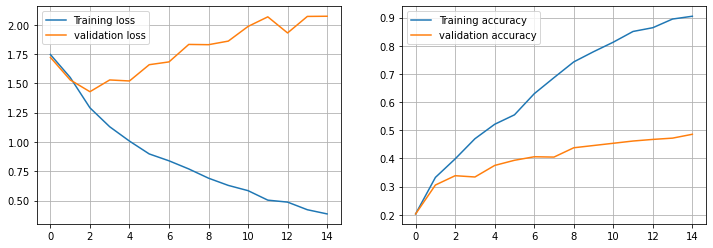

In [32]:
plot_history(history)

In [33]:
from sklearn.metrics import confusion_matrix

In [34]:
ypred = model.predict(X_test)

In [35]:
np.argmax(y_test,axis=1)

array([2, 4, 0, 1, 1, 4, 1, 1, 3, 2, 2, 1, 0, 0, 4, 0, 0, 4, 0, 4, 1, 1,
       3, 3, 2, 1, 0, 2, 2, 1, 2, 1, 1, 0, 2, 0, 1, 4, 2, 1, 1, 2, 4, 1,
       1, 1, 0, 1, 2, 1, 4, 2, 1, 3, 4, 3, 3, 3, 2, 0, 3, 1, 3, 0, 4, 1,
       2, 0, 4, 1, 3, 2, 2, 4, 0, 4, 4, 2, 3, 1, 3, 1, 4, 3, 0, 0, 1, 0,
       4, 4, 1, 0, 1, 2, 3, 2, 0, 4, 0, 3, 1, 1, 1, 1, 2, 3, 4, 4, 3, 1,
       4, 3, 4, 2, 1, 3, 0, 4, 2, 2, 2, 4, 0, 0, 0, 1, 4, 1, 0, 1, 2, 1,
       3, 2, 0, 2, 4, 3, 0, 4, 0, 4, 3, 2, 4, 2, 4, 2, 3, 2, 0, 2, 1, 3,
       4, 0, 1, 1, 1, 4, 0, 0, 1, 2, 1, 1, 3, 4, 2, 0, 1, 0, 1, 1, 0, 1,
       0, 3, 3, 2, 2, 3, 4, 1, 2, 3, 1, 0, 2, 1, 4, 1, 4, 2, 1, 3, 1, 1,
       4, 4, 4, 0, 4, 1, 2, 1, 3, 2, 0, 3, 1, 0, 3, 4, 0, 1, 0, 1, 3, 3,
       2, 0, 1, 3, 4, 0, 4, 0, 3, 3, 3, 2, 2, 0, 0, 4, 1, 2, 0, 2, 2, 3,
       3, 0, 3, 2, 4, 0, 1, 3, 4, 3, 4, 1, 1, 2, 4, 3, 4, 3, 1, 1, 1, 0,
       3, 4, 2, 3, 2, 3, 1, 1, 2, 1, 4, 1, 0, 0, 0, 1, 3, 2, 0, 1, 1, 3,
       0, 0, 2, 1, 3, 3, 4, 3, 2, 0, 0, 2, 3, 3, 1,

In [36]:
confusionmatrix=confusion_matrix(np.argmax(y_test,axis=1),np.argmax(ypred,axis=1))

In [37]:
confusionmatrix

array([[ 96,  19,  11,  35,  13],
       [ 38,  87,  10,  30,  24],
       [ 23,   7,  84,  49,  15],
       [ 30,   9,  25,  68,  30],
       [ 23,   3,  16,  27, 105]])

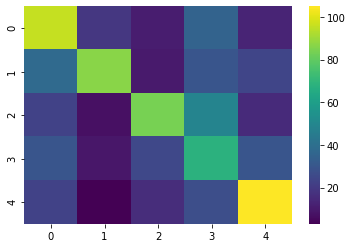

In [39]:
sns.heatmap(confusionmatrix, cmap='viridis');

## Model saving

In [40]:
# save model and other important things
model.save('model_multiclass')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model_multiclass/assets


In [41]:
import json
with open('vocab.json', 'w') as fp:
    json.dump(vocab, fp)

In [42]:
import json
with open('words.json', 'w') as fp:
    json.dump(filtered_words, fp)

In [43]:
# loading the saved model, vocab, filtered_words
from tensorflow import keras
model = keras.models.load_model('./model_multiclass')

In [44]:
with open('vocab.json', 'r') as fp:
    vocab = json.load(fp)
    
with open('words.json', 'r') as fp:
    filtered_words = json.load(fp)


## Predictions

In [47]:
def Prediction(text, model=model, vocab=vocab, filtered_words=filtered_words):
    # prepare the input text
    #text = "Google is working on self driving cars, I'm bullish on $goog"
    tokens = preprocess_twt(text)
    tokens = [word for word in tokens if word in filtered_words]
    tokens = [vocab[word] for word in tokens] 
    X_input = np.array(pad_list(tokens, MAX_SEQUENCE_LEN)).reshape(1,-1)
    
    y_out = model.predict(X_input)
    sentiment = np.argmax(y_out,axis=1)[0]+1 # to make it 1 to 5
    
    print (f"The following Tweet\n\n {text} \n\n\
    has a number {sentiment} sentiment on a scale of 1 to 5")


In [48]:
#text = "Google is working on self driving cars, I'm bullish on $goog"
text = " $AAPL had a big increase. I am really happy for this."
#text = " Sad to see the stocks going down."

Prediction(text)

The following Tweet

  $AAPL had a big increase. I am really happy for this. 

    has a number 1 sentiment on a scale of 1 to 5
